# Finra Project: Wine reviews
 * by Jinting Hang

Questions:
1. find the pair which has the moest similar distribution of in items of points
2. compute the word frequency and identify words that differentiate classes the most
3. Build a text classifier using Naive Bayes 
4. derive TFIDF matrix of wine reviewers given any taster and further compute similarity matrix
5. identify the taster that has the most similar style of wine reviews

# Index
* [Answer question 1](#Answer-question-1)
* [Answer question 2](#Answer-question-2)
* [Answer question 3](#Answer-question-3)
* [Answer question 4](#Answer-question-4)
* [Answer question 5](#Answer-question-5)

In [396]:
import numpy as np
import pandas as pd
import re
from itertools import permutations 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from scipy.stats import f
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [397]:
df_reviews = pd.read_csv('winemag-data-130k-v2.csv')
df_reviews.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Answer question 1
* find the pair which has the moest similar distribution of in items of points


In [3]:
df_reviews = df_reviews.dropna()

In [5]:
len(df_reviews['variety'].unique())

183

In [69]:
df_reviews.groupby(['variety'])['points'].value_counts()

variety            points
Abouriou           85          1
Aglianico          92          2
                   86          1
Albariño           87         13
                   88          6
                   90          6
                   89          5
                   91          4
                   86          3
                   92          3
                   84          2
                   82          1
                   85          1
                   93          1
Alicante Bouschet  87          1
                   88          1
                   90          1
                   91          1
Aligoté            87          2
Alvarelhão         85          1
Arneis             88          1
                   90          1
Auxerrois          90          4
                   89          1
Baco Noir          87          1
Barbera            89         23
                   90         23
                   88         16
                   91         14
                 

In [108]:
def similar_distribution_adv(df):
    X= df['points'].value_counts()
    return pd.Series({'Variance': X.var(), 'length':len(X)})

In [109]:
df_variety_distribution = df_reviews.groupby(['variety']).apply(similar_distribution_adv)

In [120]:
df_variety_distribution.dropna(inplace = True)
df_variety_distribution = df_variety_distribution.loc[df_variety_distribution['Variance'] != 0]

In [121]:
df_variety_distribution.head()

,Variance,length
variety,,
Aglianico,0.500000,2.0
Albariño,12.290909,11.0
Auxerrois,4.500000,2.0
Barbera,69.072727,11.0
Blaufränkisch,0.200000,5.0


In [393]:
alpha = 0.05 # threshold value to test whether two have equal variance.

In [212]:
# Get all permutations of length 2 
# calculate p_value based on ftest to see which pair has the smallest pvalue, normally if the pvalue id smaller than
#0.5, we can accept the hypothesis that two groups have the same variance, otherwise we reject the hypothesis. 

def most_similar_pair(DF):
    ind = DF.index
    perm = permutations(ind, 2) 
    similar_pair = []
    minp = 1 << 30
    for a, b in perm:
        #print('a:',a,'b:', b, DF.loc[a, 'Variance'])
        F = DF.loc[a, 'Variance'] / DF.loc[b, 'Variance']
        df1, df2 = DF.loc[a, 'length'], DF.loc[b, 'length']
        p_value = f.cdf(F, df1, df2)
        if p_value < minp:
            similar_pair = [a, b]
            minp = p_value
    return similar_pair, p_value


In [215]:
similar_pair, pvalue = most_similar_pair(df_variety_distribution)
similar_pair, pvalue

(['Fumé Blanc', 'Pinot Noir'], 1.4019283822650899e-06)

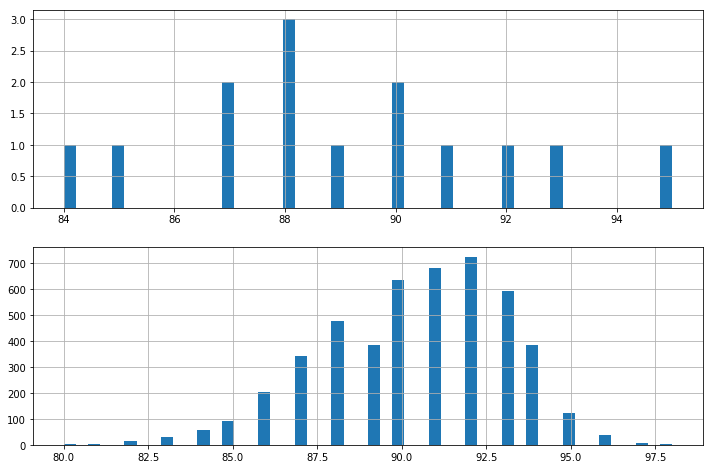

In [216]:
# plot out the most similar distribution in in terms of points
def plot_similar_pair(df, similar_pair):
    plt.figure(figsize = (12, 8))
    plt.subplot(211)
    df_test = df.loc[df['variety'] ==  similar_pair[0], 'points']
    df_test.hist(bins = 50)
    plt.subplot(212)
    df_test = df.loc[df['variety'] ==  similar_pair[1], 'points']
    df_test.hist(bins = 50)
plot_similar_pair(df_reviews, similar_pair)

### We have chosen the pair group which has the smallest pvalue as having the most similar distribution.

# Answer question 2 
* compute the word frequency and identify words that differentiate classes the most

In [407]:
df_reviews['class']  = 0
df_reviews.loc[df_reviews['points'] > 90, 'class'] = 1

In [408]:
df_reviews['class'].value_counts()

0    96336
1    33635
Name: class, dtype: int64

In [409]:
df_reviews['description'] = df_reviews['description'] + ' '

In [413]:
# analyze the frequency of words for each description
def extract_frequency(df):   
    #extract = Counter([re.sub(r'[^\w]', ' ', c) for c in df['description'].sum().split()])
    extract = Counter([c.strip("',.() ").replace(" " " ", "") for c in df['description'].sum().strip(" ' ").split()])
    return pd.Series(extract)

In [ ]:
frequency_word = df_reviews.groupby(['class']).apply(extract_frequency).unstack(level = 0)

In [ ]:
df_reviews_test = df_reviews.iloc[0: 2000]
frequency_word_test = df_reviews_test.groupby(['class']).apply(extract_frequency).unstack(level = 0)

In [ ]:
frequency_word_test.iloc[:50]

In [229]:
frequency_word.fillna(0, inplace = True)

In [398]:
# choose the most frequent 50 words for each class 
def distint_words(df):
    class_0_freq_words = df.sort_values(by = 0, ascending = False).iloc[0:50].index
    class_1_freq_words = df.sort_values(by = 1, ascending = False).iloc[0:50].index
    # use a set intersection to find out the distint words for each class
    return set(class_0_freq_words) - set(class_1_freq_words), set(class_1_freq_words) - set(class_0_freq_words)

In [400]:
distint_words(frequency_word)

({'Sauvignon', 'apple', 'has', 'light', 'offers', 'ripe', 'tart', 'vanilla'},
 {'blackberry',
  'bottling',
  'dark',
  'dried',
  'pepper',
  'shows',
  'through',
  'vineyard'})

## Answer question 3 

* Build a text classifier using Naive Bayes 

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import pandas as pd
from nltk import pos_tag
from nltk.stem import PorterStemmer

In [ ]:
def preprocessing(text):
    text2 = " ".join("".join([" " if ch in string.punctuation else ch
for ch in text]).split())
    tokens = [word for sent in nltk.sent_tokenize(text2) for word in
nltk.word_tokenize(sent)]
    tokens = [word.lower() for word in tokens]
    stopwds = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwds]
    tokens = [word for word in tokens if len(word)>=3]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    tagged_corpus = pos_tag(tokens)
    Noun_tags = ['NN','NNP','NNPS','NNS']
    Verb_tags = ['VB','VBD','VBG','VBN','VBP','VBZ']
    lemmatizer = WordNetLemmatizer()
    def prat_lemmatize(token,tag):
        if tag in Noun_tags:
            return lemmatizer.lemmatize(token,'n')
        elif tag in Verb_tags:
            return lemmatizer.lemmatize(token,'v')
        else:
            return lemmatizer.lemmatize(token,'n')
        pre_proc_text = " ".join([prat_lemmatize(token,tag) for token,tag in tagged_corpus])
    return pre_proc_text

In [238]:
## choose the first 2000 rows data
df_reviews_mini = df_reviews.iloc[:2000]
df_reviews_mini['class'].value_counts()

0    1171
1     829
Name: class, dtype: int64

In [239]:
# setting the prior, since 0s and 1s have different probability
p_0 = 1171/2000
p_1 = 829/2000

In [244]:
frequency_word_mini = df_reviews_test.groupby(['class']).apply(extract_frequency).unstack(level = 0)
frequency_word_mini.fillna(0, inplace = True)

In [250]:
frequency_word_mini = frequency_word_mini.sort_values(by = 0, ascending = False)
frequency_word_mini.head()

class,0,1
and,3084.0,2723.0
of,1641.0,1503.0
the,1550.0,1385.0
a,1449.0,1169.0
with,957.0,824.0


In [276]:
frequency_word_mini.shape[0]

7491

In [277]:
vocabulary = frequency_word_mini.index
vocabulary_class0 = frequency_word_mini.loc[frequency_word_mini[0] != 0].index
vocabulary_class1 = frequency_word_mini.loc[frequency_word_mini[1] != 0].index

In [279]:
len(vocabulary_class0)

5131

In [251]:
df_reviews_mini.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,class
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,0
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,0
23,23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi,0
25,25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa,0
35,35,US,As with many of the Erath 2010 vineyard design...,Hyland,86,50.0,Oregon,McMinnville,Willamette Valley,Paul Gregutt,@paulgwine,Erath 2010 Hyland Pinot Noir (McMinnville),Pinot Noir,Erath,0


In [349]:
X = df_reviews_mini['description']
y = df_reviews_mini['class']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
Xtrain = pd.DataFrame(Xtrain, columns = ['description'])
Xtrain.index.name = 'ID'
ytrain = pd.DataFrame(ytrain, columns = ['class'])
Xtest = pd.DataFrame(Xtest, columns = ['description'])
Xtest.index.name = 'ID'
ytest = pd.DataFrame(ytest, columns = ['class'])

In [350]:
# since it is a binary classification, we first calculate the likelihood function for each word in the vocaubulary
def assign_class(df):
    df_freq = frequency_word_mini
    val = df.values[0][0]
    _dic = Counter([word.strip(',.') for word in val.split()])
    # get conditional prob for class 1 and 0
    P_class0, P_class1 = 1, 1
    for key in _dic:
        try:
            P_class1 *= ((df_freq.loc[key, 1] + 1) / (len(vocabulary_class1) + len(vocabulary))) ** _dic[key]
            P_class0 *= ((df_freq.loc[key, 0] + 1) / (len(vocabulary_class0) + len(vocabulary))) ** _dic[key]
        except:
            continue
        
    P_class0 *= p_0 
    
    P_class1 *= p_1
    return pd.Series(0, index = ['Class']) if P_class0 > P_class1 else pd.Series(1, index = ['Class'])


In [351]:
y_train_pred = Xtrain.groupby('ID').apply(assign_class)
y_train_pred['Class'].value_counts()

0    1101
1     399
Name: Class, dtype: int64

In [354]:
print('classification_report_train: \n',classification_report(ytrain, y_train_pred))

classification_report_train: 
              precision    recall  f1-score   support

          0       0.59      0.74      0.65       879
          1       0.42      0.27      0.33       621

avg / total       0.52      0.54      0.52      1500



In [355]:
y_test_pred = Xtest.groupby('ID').apply(assign_class)
y_test_pred['Class'].value_counts()

0    372
1    128
Name: Class, dtype: int64

In [356]:
print('classification_report_test: \n',classification_report(ytest, y_test_pred))

classification_report_test: 
              precision    recall  f1-score   support

          0       0.60      0.76      0.67       292
          1       0.46      0.28      0.35       208

avg / total       0.54      0.56      0.54       500



The low precision and recall might due to the fact that I haven't removed any stop words and stemmings, if I have more time, I will implement them on both the train and test data.

# Answer question 4
* derive TFIDF matrix of wine reviewers given any taster and further compute similarity matrix

In [357]:
df_reviews_mini.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,class
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,0
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,0
23,23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi,0
25,25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa,0
35,35,US,As with many of the Erath 2010 vineyard design...,Hyland,86,50.0,Oregon,McMinnville,Willamette Valley,Paul Gregutt,@paulgwine,Erath 2010 Hyland Pinot Noir (McMinnville),Pinot Noir,Erath,0


In [379]:
# analyze the TFIDF of words for each description
def extract_TFIDF(df):   
    #extract = Counter([re.sub(r'[^\w]', ' ', c) for c in df['description'].sum().split()])
    extract = Counter([c.strip("',. ").replace(" " " ", "") for c in df['description'].sum().strip(" ' ").split()])
    n = sum(extract.values())
    # calculate the inverse frequency
    dic = {}
    for key in extract:
        dic[key] = np.log(n/ extract[key])
    
    return pd.Series(dic)

In [380]:
# IFIDF: inverse frequency of terms
grp_by_taster = df_reviews_mini.groupby('taster_name').apply(extract_TFIDF).unstack(level = 0).fillna(0)
grp_by_taster.head()

taster_name,Jim Gordon,Joe Czerwinski,Matt Kettmann,Michael Schachner,Paul Gregutt,Roger Voss,Sean P. Sullivan,Susan Kostrzewa,Virginie Boone
,0.0,0.000000,0.000000,0.0,0.0000,0.0,9.299907,0.0,0.000000
"""dry,""",0.0,5.758902,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000
$12,0.0,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,10.088846
$20,0.0,0.000000,0.000000,0.0,9.3299,0.0,0.000000,0.0,0.000000
$25,0.0,0.000000,9.903188,0.0,0.0000,0.0,0.000000,0.0,0.000000


In [385]:
# build similarity matrix
A = normalize(grp_by_taster)
similarity_matrix = A.T.dot(A)
np.fill_diagonal(similarity_matrix, 0)

In [388]:
similarity_matrix = pd.DataFrame(similarity_matrix, columns = grp_by_taster.columns, index = grp_by_taster.columns)
similarity_matrix

taster_name,Jim Gordon,Joe Czerwinski,Matt Kettmann,Michael Schachner,Paul Gregutt,Roger Voss,Sean P. Sullivan,Susan Kostrzewa,Virginie Boone
taster_name,,,,,,,,,
Jim Gordon,0.000000,17.200131,180.847054,15.393099,215.180184,2.001555,122.863583,9.964144,207.674775
Joe Czerwinski,17.200131,0.000000,22.453870,6.379032,27.393243,1.396979,16.667886,3.840653,21.176357
Matt Kettmann,180.847054,22.453870,0.000000,21.730015,375.441039,2.937266,204.398779,11.617836,404.497218
Michael Schachner,15.393099,6.379032,21.730015,0.000000,25.536940,1.124541,16.742858,3.146881,24.789757
Paul Gregutt,215.180184,27.393243,375.441039,25.536940,0.000000,2.745645,248.903781,13.895070,465.042123
Roger Voss,2.001555,1.396979,2.937266,1.124541,2.745645,0.000000,2.504328,0.915540,2.921999
Sean P. Sullivan,122.863583,16.667886,204.398779,16.742858,248.903781,2.504328,0.000000,10.069487,239.092529
Susan Kostrzewa,9.964144,3.840653,11.617836,3.146881,13.895070,0.915540,10.069487,0.000000,13.887551
Virginie Boone,207.674775,21.176357,404.497218,24.789757,465.042123,2.921999,239.092529,13.887551,0.000000


# Answer question 5
* identify the taster that has the most similar style of wine reviews

In [394]:
def find_max(df):
    return df.idxmax()

In [395]:
similarity_matrix.apply(find_max, axis = 0)

taster_name
Jim Gordon             Paul Gregutt
Joe Czerwinski         Paul Gregutt
Matt Kettmann        Virginie Boone
Michael Schachner      Paul Gregutt
Paul Gregutt         Virginie Boone
Roger Voss            Matt Kettmann
Sean P. Sullivan       Paul Gregutt
Susan Kostrzewa        Paul Gregutt
Virginie Boone         Paul Gregutt
dtype: object